In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats import norm
import datetime as dt
import seaborn as sns
from tqdm import tqdm
sns.set()

ticker = ["PYPL"]
start = dt.datetime.today()-dt.timedelta(360)
end = dt.datetime.today()
data=pd.DataFrame()
data['PYPL']= yf.download(ticker,start,end)["Adj Close"]
real_data=data['PYPL'].values #this gets all the original price changes of the security
#print(len(data['MSFT']))





[*********************100%***********************]  1 of 1 completed


In [2]:
returns = data.pct_change()
returns.dropna(inplace = True)
print(returns.head())

                PYPL
Date                
2020-10-27  0.016276
2020-10-28 -0.040513
2020-10-29  0.014196
2020-10-30 -0.045683
2020-11-02  0.008757


C:\Users\matth\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


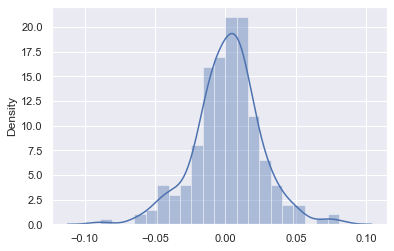

In [5]:
returns = data.pct_change()
returns.dropna(inplace = True)
sns.distplot(returns, hist = True)
plt.show()

[*********************100%***********************]  1 of 1 completed


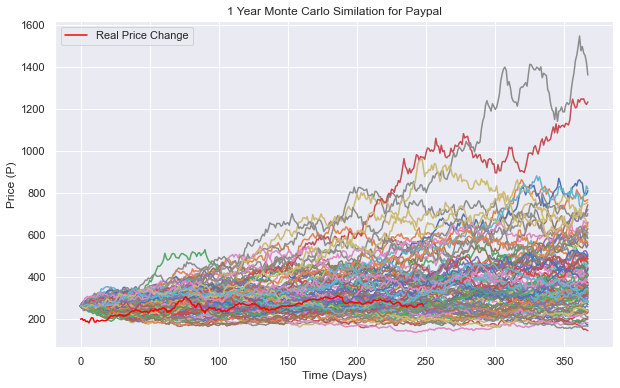

In [6]:
def get_simulation(ticker, name):
    start = dt.datetime.today()-dt.timedelta(360)
    end = dt.datetime.today()
    data=pd.DataFrame()
    data['PYPL']= yf.download(ticker,start,end)["Adj Close"]
    log_returns = np.log(1+data.pct_change())
    mean = log_returns.mean()
    var = log_returns.var()
    drift = mean - (0.5 * var)
    stdev = log_returns.std()
    t_intervals = 368
    iterations = 100 #this will determine the number of simlations we are going to run. Can be more than 10
    daily_returns = np.exp(drift.values + stdev.values * norm.ppf(np.random.rand(t_intervals, iterations)))
    s0 = data.iloc[-1]
    price_list = np.zeros_like(daily_returns)
    price_list[0] = s0
    for t in range(1, t_intervals): #creates the lists that contain the simlations created
        price_list[t] = price_list[t-1] * daily_returns[t]
    #plot the simulation
    plt.figure(figsize = (10,6))
    plt.title("1 Year Monte Carlo Similation for " + name)
    plt.ylabel("Price (P)")
    plt.xlabel("Time (Days)")
    plt.plot(price_list)
    plt.plot(real_data, color='red', label= "Real Price Change")
    plt.legend(loc='upper left')
    plt.savefig("MT_simulation.png")
    plt.show()
    



get_simulation("PYPL", "Paypal") #This can be used to change the name of the security we want to look for.

In [9]:
ticker = ["PYPL"]
start = dt.datetime.today()-dt.timedelta(360)
end = dt.datetime.today()

df = yf.download(ticker,start,end)
df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-10-26,200.660004,203.889999,195.050003,197.220001,197.220001,7716000
2020-10-27,198.789993,201.320007,197.720001,200.429993,200.429993,4754400
2020-10-28,196.960007,198.389999,191.500000,192.309998,192.309998,8050000
2020-10-29,194.080002,197.589996,192.309998,195.039993,195.039993,7627100
2020-10-30,193.289993,195.330002,182.919998,186.130005,186.130005,12029700


In [14]:

number_simulation = 300
predict_day = 200

close = df['Close'].tolist()
returns = pd.DataFrame(close).pct_change()
last_price = close[-1]
results = pd.DataFrame()
avg_daily_ret = returns.mean()
variance = returns.var()
daily_vol = returns.std()
daily_drift = avg_daily_ret - (variance / 2)
drift = daily_drift - 0.5 * daily_vol ** 2

results = pd.DataFrame()

for i in tqdm(range(number_simulation)):
    prices = []
    prices.append(df.Close.iloc[-1])
    for d in range(predict_day):
        shock = [drift + daily_vol * np.random.normal()]
        shock = np.mean(shock)
        price = prices[-1] * np.exp(shock)
        prices.append(price)
    results[i] = prices

100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:47<00:00,  6.36it/s]


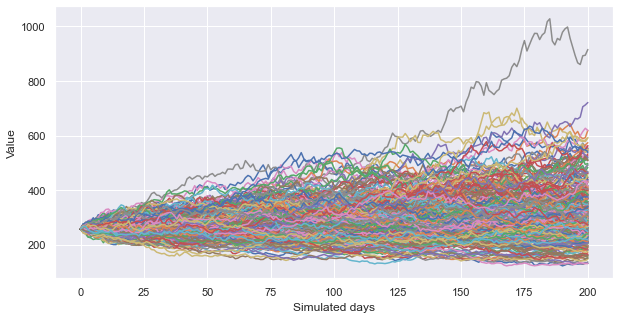

In [15]:
plt.figure(figsize=(10,5))
plt.plot(results)
plt.ylabel('Value')
plt.xlabel('Simulated days')
plt.show()

C:\Users\matth\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
<ipython-input-17-ae91ed8a6932>:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1,2,1)
C:\Users\matth\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibili

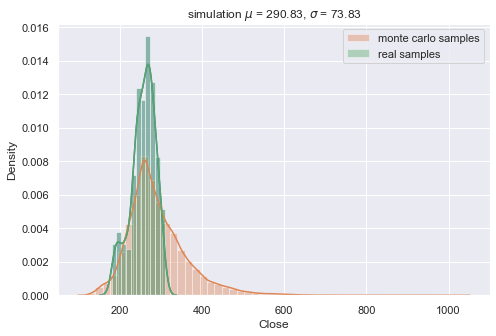

In [17]:
raveled = results.values.ravel()
raveled.sort()
cp_raveled = raveled.copy()

plt.figure(figsize=(17,5))

plt.subplot(1,2,1)
sns.distplot(df.Close,norm_hist=True)
plt.title('$\mu$ = %.2f, $\sigma$ = %.2f'%(df.Close.mean(),df.Close.std()))
plt.subplot(1,2,1)
sns.distplot(raveled,norm_hist=True,label='monte carlo samples')
sns.distplot(df.Close,norm_hist=True,label='real samples')
plt.title('simulation $\mu$ = %.2f, $\sigma$ = %.2f'%(raveled.mean(),raveled.std()))
plt.legend()
plt.show()